# IE 360 Statistical Forecasting and Time Series
# Homework 2

#  1) Introduction

In this homework, I will try to forecast the sales of UGS for every quarter of 2007 by using the data from years between 2000 and 2006 and a number of potential independent variables.

# 2) Preparing the Data

In [16]:
options(warn=-1)
library(RcppRoll)
library(readxl)
library(lubridate)
library(zoo)
library(ggplot2)
library(scales)
library(data.table)
library(corrplot)
library(ggcorrplot)
library(GGally)
library(forecast)
library(dplyr)
options(warn=0)

In [2]:
path <- "C:/Users/sonef/Desktop/IE360_Spring22_HW2_data.csv"

Homework2_Data <- read.csv(path,colClasses=c('character',rep('numeric',10)))
colnames(Homework2_Data) <- c("Quarters", "UGS", "RNUV","NLPG","PU","PG","NUGV","NDGV","GNPA","GNPC","GNPT")

Homework2_Data$Quarters <- as.Date(as.yearqtr(Homework2_Data$Quarters, format = "%Y_Q%q"))


Homework2_Training <- Homework2_Data[c(1:28),]
Homework2_Forecast <- Homework2_Data[c(29,30,31,32),]

Homework2_Training <- data.table(Homework2_Training)
Homework2_Forecast <- data.table(Homework2_Forecast)


head(Homework2_Training)

str(Homework2_Training)

Quarters,UGS,RNUV,NLPG,PU,PG,NUGV,NDGV,GNPA,GNPC,GNPT
2000-01-01,1128971,0.0146,940000,469.03,355.69,4647500,281.9853,1040173,3483132,18022686
2000-04-01,1199569,0.0205,941000,459.42,344.58,4742876,284.0813,1760460,4525451,21797130
2000-07-01,1370167,0.0207,943500,439.98,327.21,4840931,286.7169,6974808,5915204,30050207
2000-10-01,1127548,0.0163,948000,402.08,300.67,4919685,288.3137,3267125,4929778,24480153
2001-01-01,1033918,0.0071,950000,411.58,305.75,4954754,287.6237,1004528,3418387,15832648
2001-04-01,1019754,0.0051,955000,520.39,374.78,4980204,287.8814,1449357,4359831,20296918


Classes 'data.table' and 'data.frame':	28 obs. of  11 variables:
 $ Quarters: Date, format: "2000-01-01" "2000-04-01" ...
 $ UGS     : num  1128971 1199569 1370167 1127548 1033918 ...
 $ RNUV    : num  0.0146 0.0205 0.0207 0.0163 0.0071 0.0051 0.0041 0.0048 0.0012 0.0032 ...
 $ NLPG    : num  940000 941000 943500 948000 950000 ...
 $ PU      : num  469 459 440 402 412 ...
 $ PG      : num  356 345 327 301 306 ...
 $ NUGV    : num  4647500 4742876 4840931 4919685 4954754 ...
 $ NDGV    : num  282 284 287 288 288 ...
 $ GNPA    : num  1040173 1760460 6974808 3267125 1004528 ...
 $ GNPC    : num  3483132 4525451 5915204 4929778 3418387 ...
 $ GNPT    : num  18022686 21797130 30050207 24480153 15832648 ...
 - attr(*, ".internal.selfref")=<externalptr> 


# 3) Before Start (First Insights from the Data)

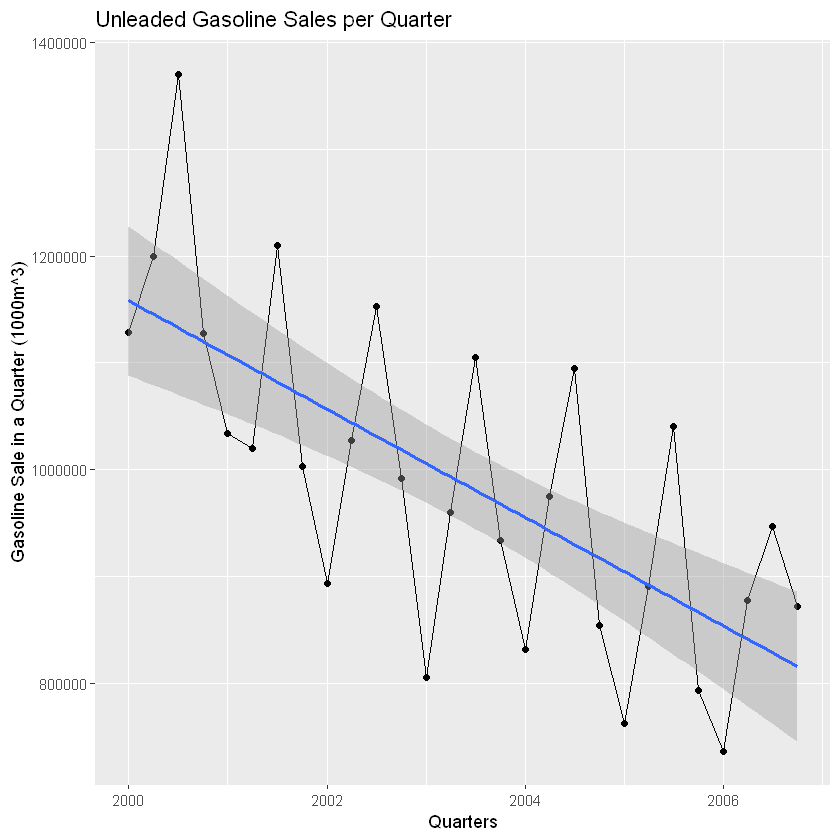

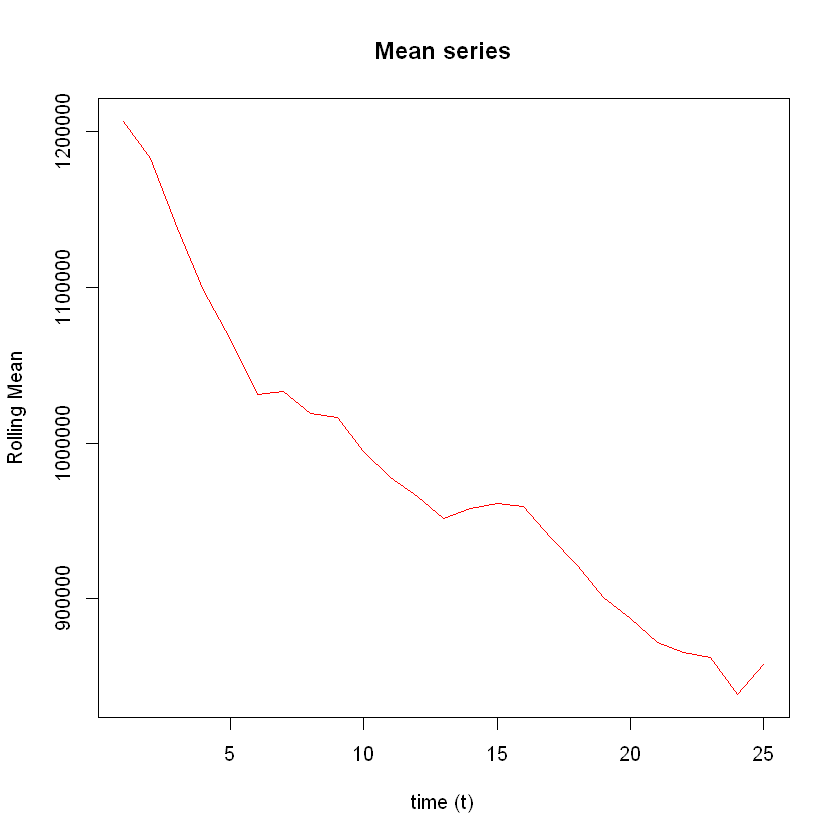

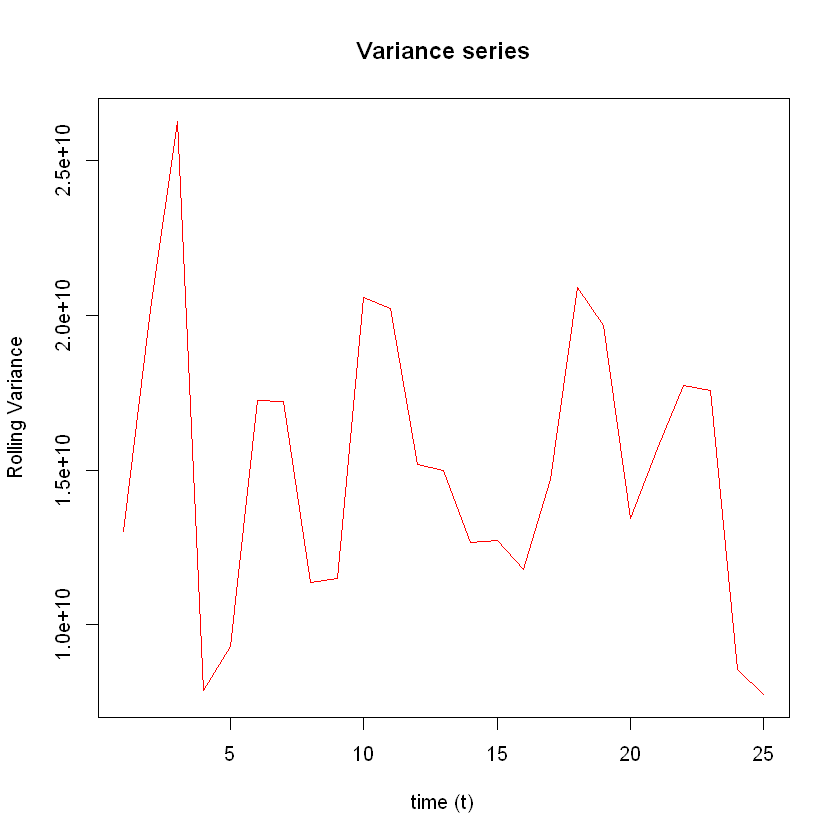

In [3]:
ggplot(Homework2_Training, aes(x=Quarters,y=UGS, group = 1)) +
geom_point() +
geom_line() +
labs(y ='Gasoline Sale in a Quarter (1000m^3)')+ 
ggtitle('Unleaded Gasoline Sales per Quarter')+
geom_smooth(formula = y ~ x, method = "lm",level=0.9)

mean_series=roll_mean(Homework2_Training$UGS,4,align='left')
var_series=roll_var(Homework2_Training$UGS,4,align='left')
plot(mean_series,
     type='l',col='red',
     xlab = "time (t)",
     ylab = "Rolling Mean",
     main = "Mean series")

plot(var_series,
     type='l',col='red',
     xlab = "time (t)",
     ylab = "Rolling Variance",
     main = "Variance series")

By looking at the time series of UGS, rolling mean series and variance series, we can clearly say that data is not stationary, E[x t] changes over time t, there is a strongly decreasing trend. Note that also variance is shrinking to the middle and then gets larger again which also indicates a non-stationary but this effect is not as significant as the mean effect.

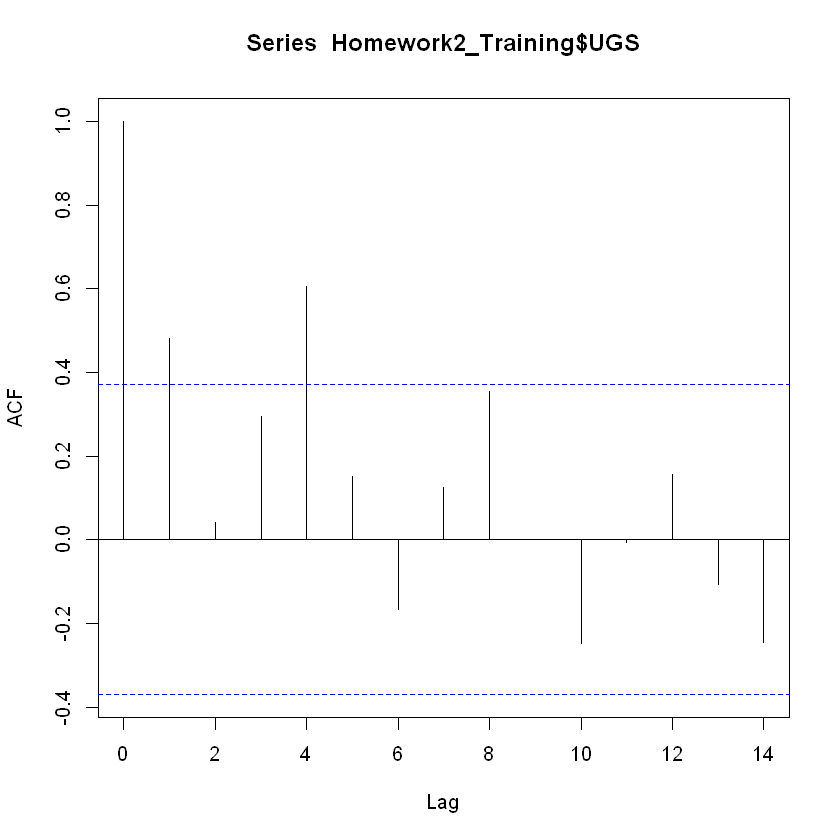

In [4]:
acf(Homework2_Training$UGS)

The UGS sales between 2000 and 2006 shows that there are strong correlations for lag 1, 4 and 8. 
Lag 1 is related to the overall decreasing trend in the data and lag 4 explains the quarterly seasonality of the data where sale in each quarter is highly correlated with the same quarter of the previous year. Note that lag 4 affect also explains the lag 8 since quarterly seasonality shows it affects no mather how many years passes or in other words, if we expect a high sale in a quarter, then we expect a high sale for 1 year later(4 quarter later), 2 years later (8 quarters later) and so on.

# 4) Forecasting with Different Models

## Model 1 - Adding Trend and Seasonality

Since the data contains a significant trend and significant seasonality, we can build a sufficiently good model by just adding trend and seasonality components without including any regressors.

In [5]:
Homework2_Training[,trend := 1:.N ]
Homework2_Training[,Quarters_:=as.character(month(Quarters))]

Homework2_Forecast[,trend := 29:32 ]
Homework2_Forecast[,Quarters_:=as.character(month(Quarters))]

Model_1 <- lm(UGS ~ trend+Quarters_, Homework2_Training)
summary(Model_1)


Call:
lm(formula = UGS ~ trend + Quarters_, data = Homework2_Training)

Residuals:
   Min     1Q Median     3Q    Max 
-81167 -31283  -3458  28640  94502 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1060372      23653  44.830  < 2e-16 ***
trend         -13497       1147 -11.764 3.28e-11 ***
Quarters_10    95049      26189   3.629 0.001405 ** 
Quarters_4    121532      25987   4.677 0.000104 ***
Quarters_7    273619      26063  10.498 3.03e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 48570 on 23 degrees of freedom
Multiple R-squared:  0.9119,	Adjusted R-squared:  0.8966 
F-statistic: 59.53 on 4 and 23 DF,  p-value: 8.446e-12


Just by adding trend and seasonality, we obtained a model with considerably low residual standard error and a good R squared value.

We can better understand how the model fit by plotting both actual and predicted values.

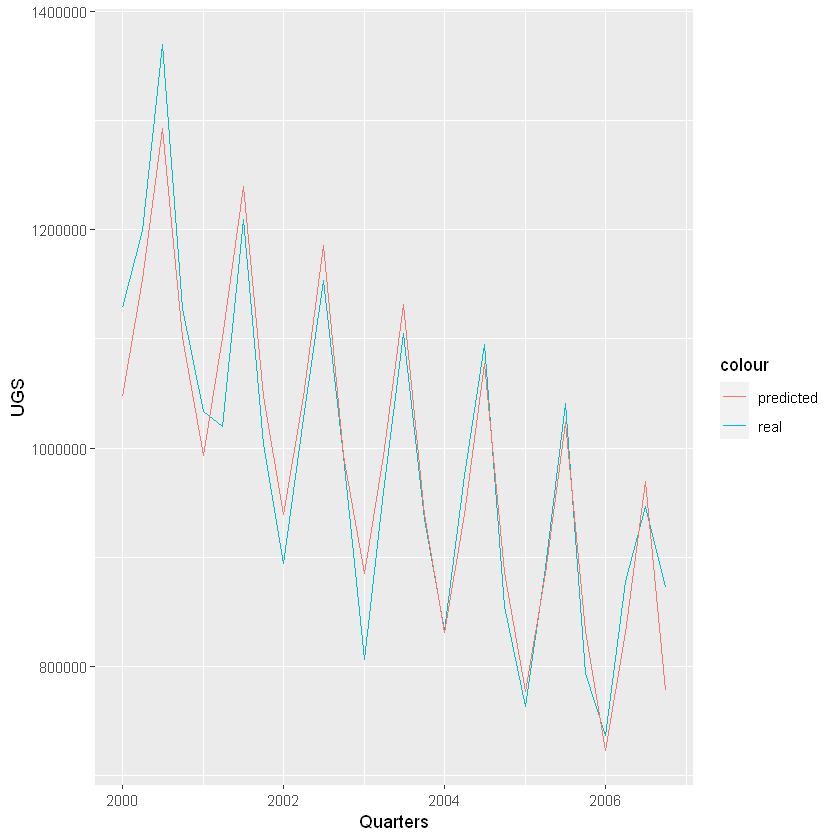

In [6]:
Plot_Model1=copy(Homework2_Training)
Plot_Model1[,actual:=UGS]
Plot_Model1[,predicted_trend:=predict(Model_1,Plot_Model1)]
Plot_Model1[,residual_trend:=actual-predicted_trend]

ggplot(Plot_Model1 ,aes(x=Quarters)) +
        geom_line(aes(y=UGS,color='real')) + 
        geom_line(aes(y=predicted_trend,color='predicted'))

Most of the quarters are estimated very well but still there are some significant errors. We can check the errors by checkresiduals.

Warning message in modeldf.default(object):
"Could not find appropriate degrees of freedom for this model."

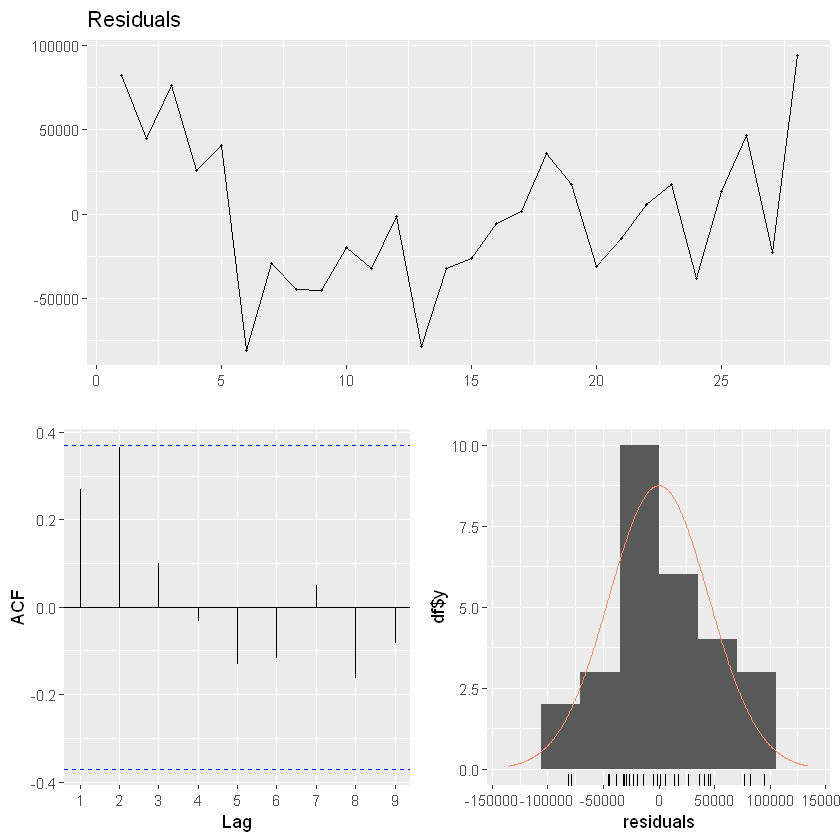

In [7]:
checkresiduals(Model_1$residuals)

Residuals seems to distribute normal but it seems like residuals do not have completely stationary mean and variance since we can see clearly negative residuals at consecutive periods between 5 and 16. Also Autocorrelation function gives a significant lag 1 value.

## Model 2 - Adding Regressors to the Model

There are many input attribute in the data and some of them may help to improve the model. We can start by checking the correlation between those attributes and also the most importantly, correlation between those attributes and Unleaded Gasoline Sales

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


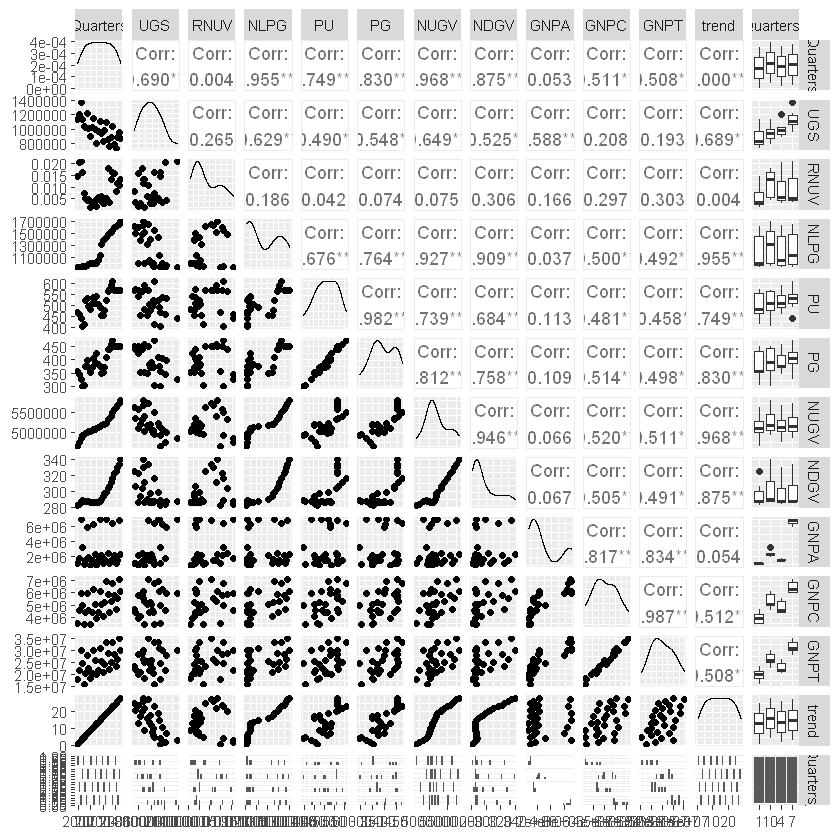

In [8]:
ggpairs(Homework2_Training)

It looks like UGS is highly correlated with NLPG,PU,PG,NUGV,NDGV and GNPA attributes. We can include all these into the model but because some of these attributes highly inter correlated, model will exclude them and mark them as unsignificant.

In [9]:
Model_2 <- lm(UGS ~ trend+NLPG+PU+PG+NUGV+NDGV+GNPA + Quarters_, Homework2_Training)
summary(Model_2)


Call:
lm(formula = UGS ~ trend + NLPG + PU + PG + NUGV + NDGV + GNPA + 
    Quarters_, data = Homework2_Training)

Residuals:
   Min     1Q Median     3Q    Max 
-67794 -10461   1987  18461  32208 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.094e+06  8.283e+05   3.735  0.00165 ** 
trend        1.514e+04  1.284e+04   1.178  0.25486    
NLPG        -2.937e-01  1.804e-01  -1.628  0.12195    
PU           2.276e+01  1.017e+03   0.022  0.98241    
PG          -1.129e+03  1.437e+03  -0.786  0.44295    
NUGV        -1.023e+00  3.343e-01  -3.061  0.00708 ** 
NDGV         1.238e+04  3.581e+03   3.456  0.00302 ** 
GNPA        -3.613e-02  2.764e-02  -1.307  0.20854    
Quarters_10  1.607e+05  4.385e+04   3.664  0.00192 ** 
Quarters_4   1.463e+05  2.356e+04   6.212 9.48e-06 ***
Quarters_7   4.953e+05  1.597e+05   3.102  0.00648 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 29700 on 17 degrees of freedom
Mu

Adding regressors to the model reduced Residual Standard Error from 48570 to 29700 and boosted the R squared value significantly. Also we can see that by adding correlated regressors, only 2 out of 6 of them turned out to be significant. Another important thing to consider is that after adding the regressors, trend became insignificant. This can be explained by the very high correlation between trend and NLPG, NUGV and NDGV attributes. 

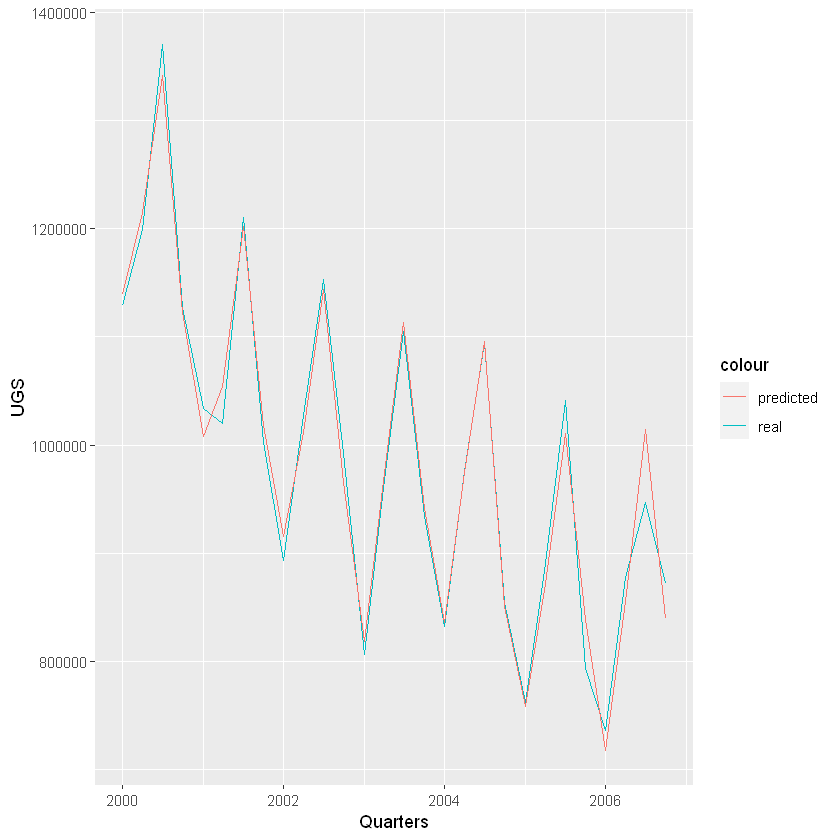

In [10]:
Plot_Model2=copy(Homework2_Training)
Plot_Model2[,actual:=UGS]
Plot_Model2[,predicted_trend:=predict(Model_2,Plot_Model2)]
Plot_Model2[,residual_trend:=actual-predicted_trend]

ggplot(Plot_Model2 ,aes(x=Quarters)) +
        geom_line(aes(y=UGS,color='real')) + 
        geom_line(aes(y=predicted_trend,color='predicted'))

Plot shows that current model predicts the actual data very well.

Warning message in modeldf.default(object):
"Could not find appropriate degrees of freedom for this model."

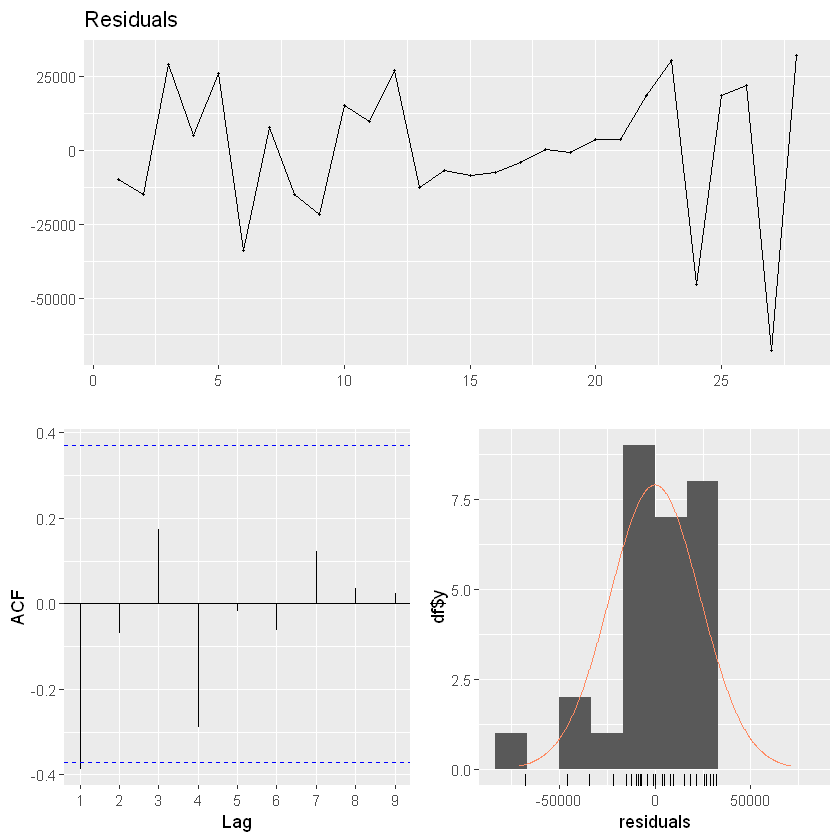

In [11]:
checkresiduals(Model_2$residuals)

Residuals of the improved model seems to have stationary mean and variance but model could not achieve to predict well at periods 24 and 27 but overall, model is a good representation of the real data.

## Model 3 - Adding Lags to the Model


Because the output attribute has a significant seasonality and some input attributes are highly correlated, we may improve the model by adding lagged values of both input attributes and output attribute. Because seasonality frequency is 4, checking the previos period (lag 1) and last year's previous period (lag 5) may help us to make a prediction.

In [12]:
Homework2_Training$UGSlag1=lag(Homework2_Training$UGS,1)

Homework2_Training$NUGVlag5=lag(Homework2_Training$NUGV,5)
Homework2_Training$NDGVlag5=lag(Homework2_Training$NDGV,5)



Call:
lm(formula = UGS ~ trend + PU + PG + NUGV + NDGV + GNPA + UGSlag1 + 
    NUGVlag5 + NDGVlag5 + Quarters_, data = Homework2_Training)

Residuals:
   Min     1Q Median     3Q    Max 
-40066  -9627    872  10043  30592 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  3.976e+06  1.964e+06   2.025  0.07042 . 
trend        1.154e+04  2.183e+04   0.528  0.60877   
PU          -5.700e+02  9.344e+02  -0.610  0.55545   
PG           3.417e+02  1.217e+03   0.281  0.78468   
NUGV        -1.447e+00  5.427e-01  -2.666  0.02363 * 
NDGV         9.099e+03  4.166e+03   2.184  0.05388 . 
GNPA        -7.666e-03  4.206e-02  -0.182  0.85901   
UGSlag1     -4.674e-01  2.370e-01  -1.972  0.07690 . 
NUGVlag5    -1.654e-01  4.570e-01  -0.362  0.72490   
NDGVlag5     1.019e+04  9.590e+03   1.062  0.31304   
Quarters_10  2.225e+05  4.861e+04   4.578  0.00101 **
Quarters_4   1.127e+05  4.237e+04   2.660  0.02389 * 
Quarters_7   3.542e+05  2.337e+05   1.515  0.16064   
---
S

Warning message in modeldf.default(object):
"Could not find appropriate degrees of freedom for this model."

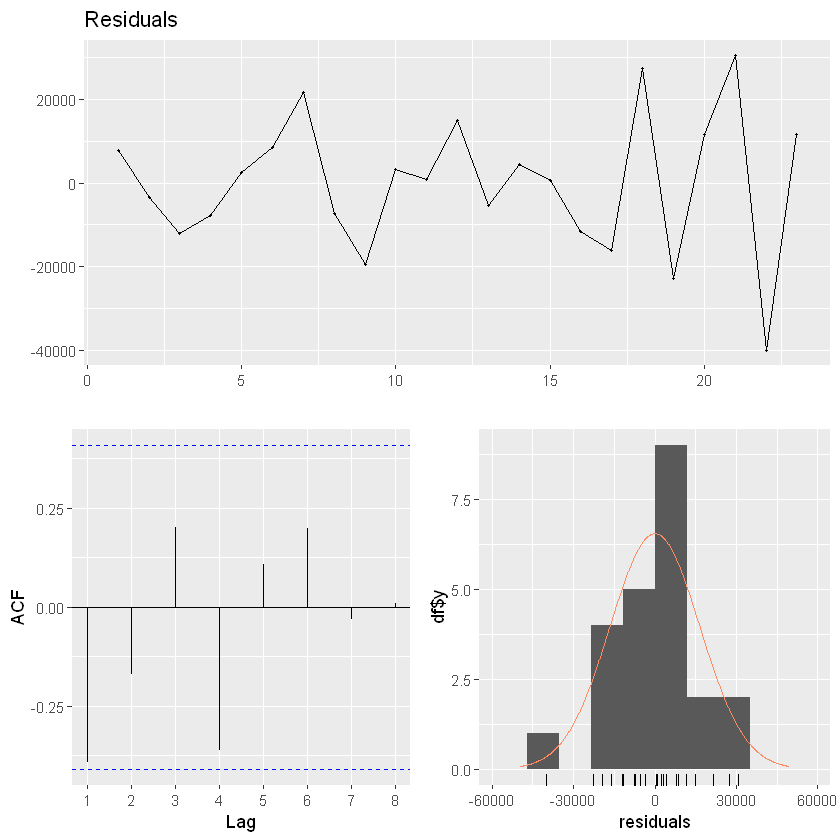

In [13]:
Model_3 <-  lm(UGS ~ trend+PU+PG+NUGV+NDGV+GNPA +UGSlag1+NUGVlag5+NDGVlag5 + Quarters_, Homework2_Training)
summary(Model_3)
checkresiduals(Model_3$residuals)

I tried several combinations of lagged input attributes and output attribute and this seems to be the one with the best prediction in terms of both Adjustes R squared and Residual Standard Error. Plot of the model and the actual values is below.

Warning message:
"Removed 5 row(s) containing missing values (geom_path)."

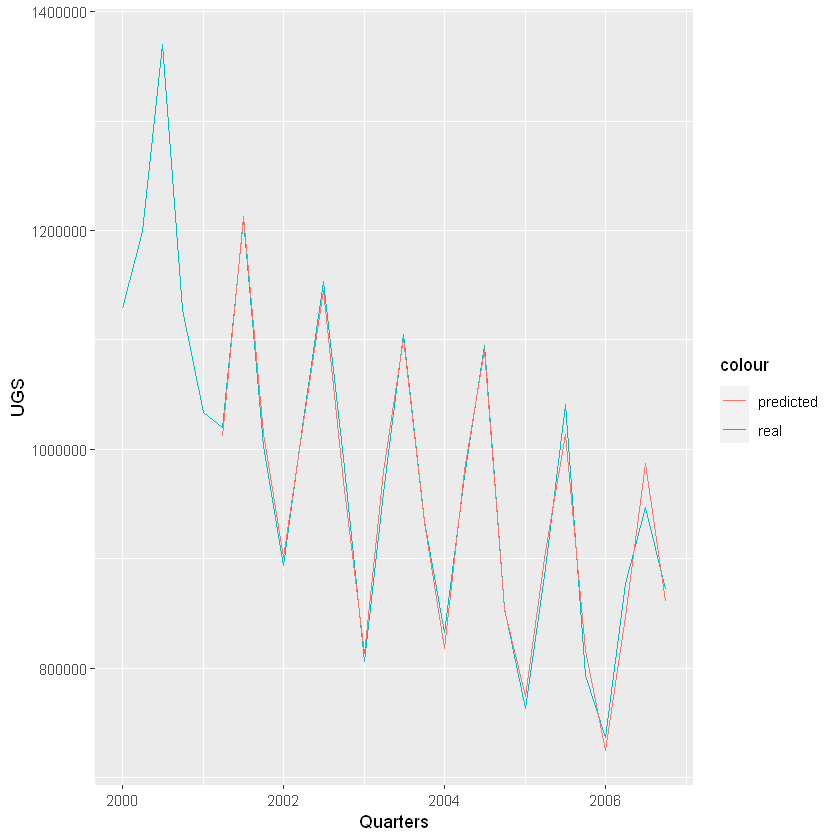

In [14]:
Plot_Model3=copy(Homework2_Training)
Plot_Model3[,actual:=UGS]
Plot_Model3[,predicted_trend:=predict(Model_3,Plot_Model3)]
Plot_Model3[,residual_trend:=actual-predicted_trend]

ggplot(Plot_Model3 ,aes(x=Quarters)) +
        geom_line(aes(y=UGS,color='real')) + 
        geom_line(aes(y=predicted_trend,color='predicted'))

This will be my final model to use to predict the 2007 values.

## Predictions

In [15]:
Homework2_Forecast$UGSlag1[1]=Homework2_Training$UGS[28]

Homework2_Forecast$NUGVlag5[1]=Homework2_Training$NUGV[24]
Homework2_Forecast$NDGVlag5[1]=Homework2_Training$NDGV[24]



Homework2_Forecast[1,"UGS"]=as.numeric(predict(Model_3,newdata=Homework2_Forecast[1,]))
Homework2_Forecast$UGSlag1[2]=as.numeric(Homework2_Forecast[1,"UGS"])


Homework2_Forecast[2,"UGS"]=predict(Model_3,newdata=Homework2_Forecast[2,])
Homework2_Forecast$UGSlag1[3]=as.numeric(Homework2_Forecast[2,"UGS"])

Homework2_Forecast[3,"UGS"]=predict(Model_3,newdata=Homework2_Forecast[3,])
Homework2_Forecast$UGSlag1[4]=as.numeric(Homework2_Forecast[3,"UGS"])

Homework2_Forecast[4,"UGS"]=predict(Model_3,newdata=Homework2_Forecast[4,])
Homework2_Forecast[,"UGS"]

UGS
703607.2
856392.2
949572.2
767725.5


#  5) Forecasts for year 2007

1st Quarter - 703607.2

2nd Quarter - 856392.2

3rd Quarter - 949572.2

4th Quarter - 767725.5


#  6) Conclusion

This homework aimed to analyze UGS data with respect to some input attributes and build several models of regression in order to be used for forecasting. My final model contains Quarterly Seasonality, PU, PG, NUGV, NDGV, GNPA, UGSlag1,NUGVlag5 and NDGVlag5 as regressors. 


I started with visual inspectation of the data and then, I noticed data was not stationary. Firstly, I added trend and seasonality which improved the model significantly. Secondly, I added the given input as regressors to the model which improved the model in an important amount. Lastly, I added lagged values of the both output attribute and some input attributes to the model which improved the model slightly.